# Introduction to NLP

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import bcolz
import re
import itertools
from numpy.random import random, permutation, randn, normal, uniform, choice
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

We're going to look at the IMDB dataset, which contains movie reviews from IMDB, along with their sentiment.

We will compare to the [stanford paper](http://ai.stanford.edu/~amaas/papers/wvSent_acl2011.pdf)

In [2]:
#data_folder = '/home/lelarge/courses/data/imdb/'
data_folder = '/home/ubuntu/data/imdb/'
data_imdb = data_folder+'imdb_full.pkl'
data_idx = data_folder+'idx.pkl'

In [3]:
arr = np.array([[1,2,4,5],[4,3,2,0]])

In [4]:
arr[0,:]

array([1, 2, 4, 5])

In [5]:
arr.shape

(2, 4)

In [6]:
embedding_dim = 3
embedding_user = nn.Embedding(6, embedding_dim)
input = Variable(torch.LongTensor([[1,2,4,5],[4,3,2,0]]))
embedding_user(input)

Variable containing:
(0 ,.,.) = 
 -0.9081 -0.3659  0.9754
  0.7832  0.3441 -0.6831
  1.3972  0.5878 -0.8989
  0.6753 -0.4978  0.0087

(1 ,.,.) = 
  1.3972  0.5878 -0.8989
 -2.4378  0.9506 -0.0558
  0.7832  0.3441 -0.6831
 -0.8118  1.9502 -0.4075
[torch.FloatTensor of size 2x4x3]

In [7]:
embedding_user(input).view(2,12)

Variable containing:

Columns 0 to 9 
-0.9081 -0.3659  0.9754  0.7832  0.3441 -0.6831  1.3972  0.5878 -0.8989  0.6753
 1.3972  0.5878 -0.8989 -2.4378  0.9506 -0.0558  0.7832  0.3441 -0.6831 -0.8118

Columns 10 to 11 
-0.4978  0.0087
 1.9502 -0.4075
[torch.FloatTensor of size 2x12]

In [8]:
embedding_user(input).permute(0,2,1)

Variable containing:
(0 ,.,.) = 
 -0.9081  0.7832  1.3972  0.6753
 -0.3659  0.3441  0.5878 -0.4978
  0.9754 -0.6831 -0.8989  0.0087

(1 ,.,.) = 
  1.3972 -2.4378  0.7832 -0.8118
  0.5878  0.9506  0.3441  1.9502
 -0.8989 -0.0558 -0.6831 -0.4075
[torch.FloatTensor of size 2x3x4]

In [9]:
#need to be done only once
#!wget -O $data_imdb https://s3.amazonaws.com/text-datasets/imdb_full.pkl

In [10]:
import pickle
f = open(data_imdb,'rb')
(x_train, labels_train), (x_test, labels_test) = pickle.load(f)

In [11]:
len(x_train)

25000

In [12]:
g = open(data_idx, 'rb')
idx = pickle.load(g)

This is the word list:

In [13]:
idx_arr = sorted(idx, key=idx.get)
idx_arr[:10]

['the', 'and', 'a', 'of', 'to', 'is', 'br', 'in', 'it', 'i']

This is the mapping from id to word

In [14]:
idx2word = {v: k for k, v in idx.items()}

Here's the 1st review. As you see, the words have been replaced by ids.

In [15]:
', '.join(map(str, x_train[0]))

'23022, 309, 6, 3, 1069, 209, 9, 2175, 30, 1, 169, 55, 14, 46, 82, 5869, 41, 393, 110, 138, 14, 5359, 58, 4477, 150, 8, 1, 5032, 5948, 482, 69, 5, 261, 12, 23022, 73935, 2003, 6, 73, 2436, 5, 632, 71, 6, 5359, 1, 25279, 5, 2004, 10471, 1, 5941, 1534, 34, 67, 64, 205, 140, 65, 1232, 63526, 21145, 1, 49265, 4, 1, 223, 901, 29, 3024, 69, 4, 1, 5863, 10, 694, 2, 65, 1534, 51, 10, 216, 1, 387, 8, 60, 3, 1472, 3724, 802, 5, 3521, 177, 1, 393, 10, 1238, 14030, 30, 309, 3, 353, 344, 2989, 143, 130, 5, 7804, 28, 4, 126, 5359, 1472, 2375, 5, 23022, 309, 10, 532, 12, 108, 1470, 4, 58, 556, 101, 12, 23022, 309, 6, 227, 4187, 48, 3, 2237, 12, 9, 215'

The ids can be looked up in idx2word.

In [16]:
idx2word[23022]

'bromwell'

In [17]:
' '.join([idx2word[o] for o in x_train[0]])

"bromwell high is a cartoon comedy it ran at the same time as some other programs about school life such as teachers my 35 years in the teaching profession lead me to believe that bromwell high's satire is much closer to reality than is teachers the scramble to survive financially the insightful students who can see right through their pathetic teachers' pomp the pettiness of the whole situation all remind me of the schools i knew and their students when i saw the episode in which a student repeatedly tried to burn down the school i immediately recalled at high a classic line inspector i'm here to sack one of your teachers student welcome to bromwell high i expect that many adults of my age think that bromwell high is far fetched what a pity that it isn't"

Reduce vocab size by setting rare words to max index.

In [18]:
vocab_size = 5000

In [19]:
trn = [np.array([i if i<vocab_size-1 else vocab_size-1 for i in s]) for s in x_train]
test = [np.array([i if i<vocab_size-1 else vocab_size-1 for i in s]) for s in x_test]

Look at distribution of lengths of sentences.

In [20]:
lens = np.array(list(map(len, trn)))
(lens.max(), lens.min(), lens.mean())

(2493, 10, 237.71364)

Pad (with zero) or truncate each sentence to make consistent length.

In [21]:
seq_len = 500

trn_pad = np.zeros((len(x_train),seq_len)).astype(np.int32)
test_pad = np.zeros((len(x_test),seq_len)).astype(np.int32)

for idx, s in enumerate(trn):
    trunc = s[-seq_len:]
    trn_pad[idx, -len(trunc):] = trunc

for idx, s in enumerate(test):
    trunc = s[-seq_len:]
    test_pad[idx, -len(trunc):] = trunc

In [22]:
trn_pad[:5,:]

array([[  0,   0,   0, ...,  12,   9, 215],
       [  0,   0,   0, ...,   5, 336, 406],
       [  0,   0,   0, ...,   6, 176, 397],
       [  0,   0,   0, ...,  14,   3, 482],
       [  0,   0,   0, ...,  65, 528,  70]], dtype=int32)

In [23]:
trn_pad.shape

(25000, 500)

In [24]:
test_pad.shape

(25000, 500)

In [25]:
use_gpu = torch.cuda.is_available()
print('Using gpu: %s ' % use_gpu)

Using gpu: True 


In [26]:
labels_test[:5]

[1, 1, 1, 1, 1]

# Single hidden layer NN

In [27]:
import imp

import NLPModel; imp.reload(NLPModel)
from NLPModel import SentimentModel

model = SentimentModel(embedding_dim = 32, vocab_size = vocab_size, seq_len=seq_len, n_iter = 3)

To be corrected: warning below.

In [28]:
%%time
model.fit(trn_pad, labels_train, test_pad, labels_test)

/home/ubuntu/.virtualenvs/deep/lib/python3.5/site-packages/torch/nn/functional.py:767: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
/home/ubuntu/.virtualenvs/deep/lib/python3.5/site-packages/torch/nn/functional.py:767: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Epoch 0: train loss 0.4476476582076848 train acc 0.7519421355498721 validation loss 0.29749024981427985 validation acc 0.8726023017902813
Epoch 1: train loss 0.165314518667929 train acc 0.9381473785166241 validation loss 0.3388802878310918 validation acc 0.8658248081841433
Epoch 2: train loss 0.043389594970780716 train acc 0.9875719309462916 validation loss 0.4575463059117727 validation acc 0.8581042199488491
CPU times: user 1min 8s, sys: 396 ms, total: 1min 8s
Wall time: 38.9 s


# Exercise: Single conv layer with max pooling



In [29]:
import nlp_models
from nlp_models import ConvModel

net = ConvModel(embedding_dim = 32, vocab_size = vocab_size,seq_len=seq_len)

model = SentimentModel(net = net,embedding_dim = 32, vocab_size = vocab_size, seq_len=seq_len, n_iter = 5,use_cuda = use_gpu)

In [30]:
%%time
model.fit(trn_pad, labels_train, test_pad, labels_test)

/home/ubuntu/.virtualenvs/deep/lib/python3.5/site-packages/torch/nn/functional.py:767: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
/home/ubuntu/.virtualenvs/deep/lib/python3.5/site-packages/torch/nn/functional.py:767: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Epoch 0: train loss 0.38119492087217854 train acc 0.8082960358056266 validation loss 0.27711543473212613 validation acc 0.8838235294117647
Epoch 1: train loss 0.20979606562182115 train acc 0.9167119565217391 validation loss 0.2786899733611995 validation acc 0.8875559462915601
Epoch 2: train loss 0.15314350200964666 train acc 0.9420556265984654 validation loss 0.30860273574319336 validation acc 0.8817215473145781
Epoch 3: train loss 0.09336841216696726 train acc 0.9673113810741688 validation loss 0.39023069759159135 validation acc 0.8771419437340153
Epoch 4: train loss 0.03967312184612617 train acc 0.9863251278772378 validation loss 0.5360847840662045 validation acc 0.869900895140665
CPU times: user 51.7 s, sys: 9.46 s, total: 1min 1s
Wall time: 1min 1s


# GloVe Embedding

[Global Vectors for Word Representation](https://nlp.stanford.edu/projects/glove/) by  Jeffrey Pennington,   Richard Socher,   Christopher D. Manning 

In [31]:
#glove_folder = '/home/lelarge/courses/data/glove/'
glove_folder = '/home/ubuntu/data/glove/'
glove_file = glove_folder + '6B.50d.tgz'

In [32]:
#need to be done only once
#%mkdir -p $glove_folder
#!wget -O $glove_file http://files.fast.ai/models/glove/6B.50d.tgz

In [33]:
import tarfile

tar = tarfile.open(glove_file, "r:gz")
tar.extractall(glove_folder)
tar.close()

In [34]:
def load_vectors(loc):
    return (load_array(loc+'.dat'),
        pickle.load(open(loc+'_words.pkl','rb'), encoding='latin1'),
        pickle.load(open(loc+'_idx.pkl','rb'),encoding='latin1'))

In [35]:
def load_array(fname):
    return bcolz.open(fname)[:]

In [36]:
glove_loc =glove_folder+'6B.50d'
vecs, words, wordidx = load_vectors(glove_loc)

In [37]:
vecs.shape

(400000, 50)

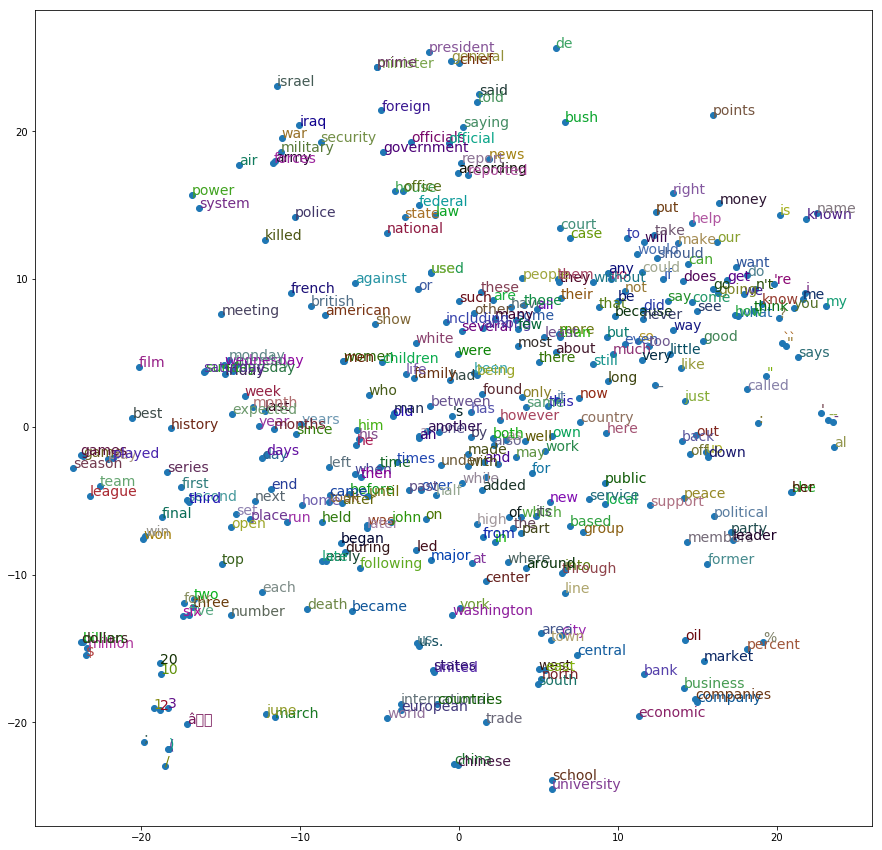

In [38]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)
Y = tsne.fit_transform(vecs[:500])

start=0; end=350
dat = Y[start:end]
plt.figure(figsize=(15,15))
plt.scatter(dat[:, 0], dat[:, 1])
for label, x, y in zip(words[start:end], dat[:, 0], dat[:, 1]):
    plt.text(x,y,label, color=np.random.rand(3)*0.7,
                 fontsize=14)
plt.show()

In [39]:
def create_emb():
    n_fact = vecs.shape[1]
    emb = np.zeros((vocab_size, n_fact))

    for i in range(1,len(emb)):
        word = idx2word[i]
        if word and re.match(r"^[a-zA-Z0-9\-]*$", word):
            src_idx = wordidx[word]
            emb[i] = vecs[src_idx]
        else:
            # If we can't find the word in glove, randomly initialize
            emb[i] = normal(scale=0.6, size=(n_fact,))

    # This is our "rare word" id - we want to randomly initialize
    emb[-1] = normal(scale=0.6, size=(n_fact,))
    emb/=3
    return emb

In [40]:
emb = create_emb()

In [41]:
emb.shape

(5000, 50)

In [42]:
emb[1,:]

array([  1.39333338e-01,   8.32266659e-02,  -1.37473335e-01,
         4.05666654e-02,   1.15090003e-01,  -1.48189999e-02,
        -1.65626665e-01,  -5.95399986e-02,  -2.20076666e-04,
        -2.18866666e-01,   9.28100049e-02,  -4.92233336e-02,
        -1.85590009e-01,   4.88599986e-02,  -3.16983337e-03,
         3.88599994e-03,   3.40133334e-02,  -4.26400006e-02,
        -2.81433324e-01,  -4.06033322e-02,  -5.60033321e-03,
        -1.10929996e-01,  -5.17333349e-02,  -7.71033317e-02,
        -6.39366657e-02,  -6.27433340e-01,  -2.55819996e-01,
         3.30169996e-02,  -1.40416662e-01,  -6.50866677e-02,
         1.33570004e+00,  -6.19799991e-02,  -1.74290001e-01,
        -1.05603337e-01,   1.97376668e-04,   2.48163333e-03,
         5.92600008e-02,  -5.29899995e-02,   4.01366657e-03,
        -1.80743337e-02,  -9.95699962e-02,  -5.24966667e-02,
        -1.15859995e-01,  -1.52123335e-02,  -1.47503336e-01,
         6.26166662e-02,   9.28299967e-04,  -6.13700002e-02,
        -3.83799995e-02,